In [ ]:
import pandas as pd

In [ ]:
wine = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/wine.csv")
wine.head()

,Wine,Alcohol,Malic.acid,Ash,Acl,Mg,Phenols,Flavanoids,Nonflavanoid.phenols,Proanth,Color.int,Hue,OD,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [ ]:
wine.describe()

,Wine,Alcohol,Malic.acid,Ash,Acl,Mg,Phenols,Flavanoids,Nonflavanoid.phenols,Proanth,Color.int,Hue,OD,Proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,1.938202,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.775035,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,1.000000,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,1.000000,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,2.000000,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,3.000000,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,3.000000,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


In [1]:
# 와인데이터 세트를 활용한 KD
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from scipy.special import softmax

In [2]:
# 1. 데이터 로딩 및 전처리
data = load_wine()
X = StandardScaler().fit_transform(data.data)
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [3]:
# 2. Teacher 모델 훈련 (복잡하고 무거운 모델)
teacher = MLPClassifier(hidden_layer_sizes=(64, 64), max_iter=1000, random_state=42)
teacher.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(64, 64), max_iter=1000, random_state=42)

In [4]:
# 3. Student 모델 정의 (경량화 모델)
student = MLPClassifier(hidden_layer_sizes=(16,), max_iter=1, warm_start=True, random_state=42)

In [5]:
# 4. 지식 증류 손실 함수
def kl_divergence(p, q):
    return np.sum(p * (np.log(p + 1e-10) - np.log(q + 1e-10)), axis=1).mean()

def distillation_loss(student_logits, teacher_logits, true_labels, temperature=2.0, alpha=0.7):
    teacher_soft = softmax(teacher_logits / temperature, axis=1)
    student_soft = softmax(student_logits / temperature, axis=1)
    kd_loss = kl_divergence(teacher_soft, student_soft) * (temperature ** 2)
    ce_loss = -np.log(student_soft[range(len(true_labels)), true_labels] + 1e-10).mean()
    return alpha * kd_loss + (1 - alpha) * ce_loss


In [6]:
# 5. Student 훈련
losses = []
for epoch in range(50):
    student.partial_fit(X_train, y_train, classes=np.unique(y_train))
    teacher_logits = teacher.predict_proba(X_train)
    student_logits = student.predict_proba(X_train)

    loss = distillation_loss(student_logits, teacher_logits, y_train)
    losses.append(loss)
    print(f"Epoch {epoch + 1:02d} - Distillation Loss: {loss:.4f}")

Epoch 01 - Distillation Loss: 0.3858
Epoch 02 - Distillation Loss: 0.3841
Epoch 03 - Distillation Loss: 0.3824
Epoch 04 - Distillation Loss: 0.3808
Epoch 05 - Distillation Loss: 0.3791
Epoch 06 - Distillation Loss: 0.3774
Epoch 07 - Distillation Loss: 0.3757
Epoch 08 - Distillation Loss: 0.3741
Epoch 09 - Distillation Loss: 0.3724
Epoch 10 - Distillation Loss: 0.3708
Epoch 11 - Distillation Loss: 0.3692
Epoch 12 - Distillation Loss: 0.3676
Epoch 13 - Distillation Loss: 0.3660
Epoch 14 - Distillation Loss: 0.3644
Epoch 15 - Distillation Loss: 0.3628
Epoch 16 - Distillation Loss: 0.3613
Epoch 17 - Distillation Loss: 0.3597
Epoch 18 - Distillation Loss: 0.3582
Epoch 19 - Distillation Loss: 0.3567
Epoch 20 - Distillation Loss: 0.3552
Epoch 21 - Distillation Loss: 0.3537
Epoch 22 - Distillation Loss: 0.3523
Epoch 23 - Distillation Loss: 0.3508
Epoch 24 - Distillation Loss: 0.3494
Epoch 25 - Distillation Loss: 0.3480
Epoch 26 - Distillation Loss: 0.3466
Epoch 27 - Distillation Loss: 0.3452
E

In [8]:
# 6. 평가
y_pred_teacher = teacher.predict(X_test)
y_pred_student = student.predict(X_test)

teacher_acc = accuracy_score(y_test, y_pred_teacher)
student_acc = accuracy_score(y_test, y_pred_student)

print("\n=== 최종 정확도 ===")
print(f"Teacher 모델 정확도: {teacher_acc * 100:.2f}%")
print(f"Student 모델 정확도: {student_acc * 100:.2f}%")


=== 최종 정확도 ===
Teacher 모델 정확도: 100.00%
Student 모델 정확도: 88.89%


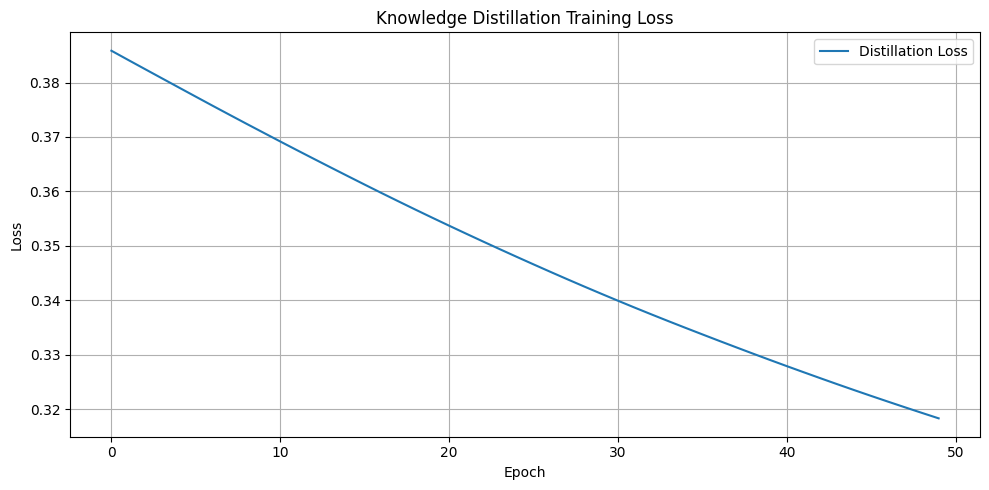

In [9]:
# 7. 손실 시각화
plt.figure(figsize=(10, 5))
plt.plot(losses, label='Distillation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Knowledge Distillation Training Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()